# Embedding explorer

In this tutorial, we'll create a notebook-based Embeddings explorer. We will use functions, or **Weave Ops**, defined in the Weave ecosystem so that they're available to compatible types in the Weave UI.

You'll learn how to:
- Save and version embeddings
- Build an interactive embeddings explorer using Weave
- Use the Weave ecosystem to: 
    - Embed a string column using OpenAI Embeddings
    - Cluster & project the embeddings using umap

Note: we will follow the clustering / projection approach from here: https://umap-learn.readthedocs.io/en/latest/clustering.html

## Import Dependencies

Make sure you have weave installed.

In [ ]:
!pip install weave openai tiktoken tenacity hdbscan

In [ ]:
import pandas
import weave
from weave.legacy.ecosystem import openai
from weave.legacy.ecosystem import umap
from weave.legacy.ecosystem import hdbscan

## Download the data

We'll use a pokemon dataset from https://calmcode.io/datasets/pokemon.json.

In [ ]:
!curl -O https://calmcode.io/datasets/pokemon.json

## Read the data and save it to Weave

Weave will store and version the data locally under the name you pass as the second argument to `weave.save`.

In [ ]:
raw_data = pandas.read_json('./pokemon.json')
data = weave.save(weave.legacy.ops.dataframe_to_arrow(raw_data), 'pokemon_data')

We can show the data by executing it in a notebook, this will call `weave.show` on it.

In [ ]:
data # or weave.show(data)

You can change the type of the displayed weave panel by changing `Table` to `Plot` and it will intelligently change to display a plot of the data.
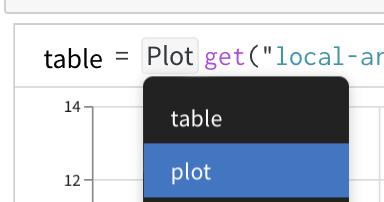

You've now created a Weave `Plot` Panel, or **Weave PanelPlot**. The default PanelPlot will show the HP (hit points or health points) of all the Pokemon versus their total stats. From the resulting PanelPlot, you can 
* hover your mouse over a point to see the full data for it in the tooltip
* click on the magnifuing glass in the bottom right corner, then click and drag over a region of the plot to rescale and zoom to the selected region
* double-click on the plot area to reset to the original zoom level

## Embed and cluster the data

Now we can pass a column from this data to another Weave Op to embed it. This will turn each row in the column `name` into a vector.

In [ ]:
embeddings = openai.openai_embed(data['name'], {"model": "text-embedding-ada-002"})

Now, we'll project this to 2 dimensions for clustering, and then we'll cluster this projection using `hdbscan`.

In [ ]:
clusterable_projection = umap.umap_project(
    embeddings, {
        'n_neighbors': 30,
        'min_dist': 0,
        'n_components': 2,
    }
)

In [ ]:
clusters = hdbscan.hdbscan_cluster(clusterable_projection, {
            'min_samples': 10,
            'min_cluster_size': 60
        })

Then, we'll project the embeddings again for plotting. For efficient computation, Weave isn't actually executing anything until we call `weave.use` or `weave.show` on the built-up computation (or "compute graph").

In [ ]:
projection = umap.umap_project(embeddings, {})

## Combine data for plotting

Finally, we'll combine our data into one big table so we can display the Pokemon name and types alongside our embedding. Here, we're calling `weave.use` on each weave object to execute the computation, and then we're merging them into a new list of dictionaries. 

In [ ]:
weave.show([{'x': x, 'y': y, 'k':k, 'd':d} for (x,y),k,d in 
            zip(weave.use(projection),
                weave.use(clusters),
                weave.use(data))])

## Build and publish an interactive dashboard

Some Weave UI tips to build an interactive dashboard in-line to explore and get insights into your embeddings:
* **add new panels**: click the + button on the drawer that pops out on the right hand side of the cell
* **change panel types**: as we did above to change the `Table` panel named `pokemon_data` into a `Plot` panel
* **refer to other panels by their name**: add a new `plot` panel that uses `table.selected_data` from the first panel. You can click the pencil to edit the configuration of your `plot`. 

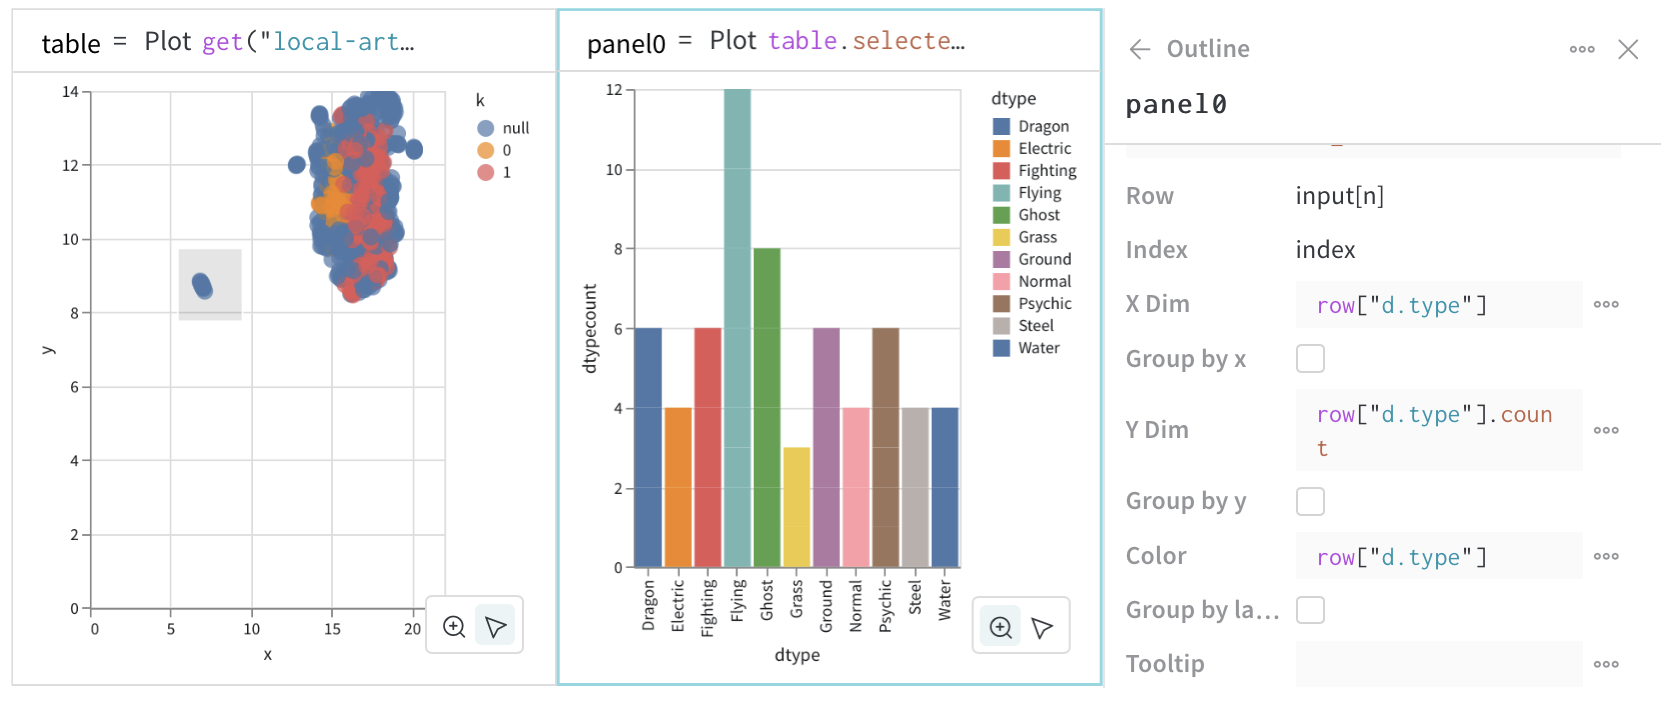

To share your creation, you can click "open in new tab" in the right-hand drawer, and then click "Publish" to save it to wandb.

### Bonus: Weaving everything together

Here's a **Weave Board** for all these panels, defined in code. We're actively working on additional examples and tutorials to explain these concepts in more detail. To inspire some initial exploration, you can:
* **open the panel in a new window** from the right-hand drawer on hover, to view a full-page Weave Board
* **see the details of selected data** by clicking the mouse button in the bottom right of the PanelPlot, then clicking and dragging to select a subregion of points
* **customize the Board** by adding, changing, and interconnecting panels
* **save and share your work** by renaming the Board and publishing it to W&B

In [ ]:
weave.legacy.panels.Board(
    vars={
        'data': data,
        'limit': 1005,
        'limited_data': lambda data, limit: data.limit(limit),
        'embeddings': lambda limited_data: openai.openai_embed(limited_data['name'], {"model": "text-embedding-ada-002"}),
        'clusterable_projection': lambda embeddings: umap.umap_project(
            embeddings, {
                'n_neighbors': 30,
                'min_dist': 0,
                'n_components': 2,
            }
        ),
        'clusters': lambda clusterable_projection: hdbscan.hdbscan_cluster(clusterable_projection, {
            'min_samples': 10,
            'min_cluster_size': 50
        }),
        'projection': lambda embeddings: umap.umap_project(embeddings, {})
    },
    panels=[
        weave.legacy.panels.BoardPanel(
            lambda limited_data, projection, clusters: weave.legacy.panels.Plot(
                limited_data,
                x=lambda row, index: projection[index][0],
                y=lambda row, index: projection[index][1],
                label=lambda row, index: clusters[index],
            ),
            id='projection_plot',
            layout=weave.legacy.panels.BoardPanelLayout(x=0, y=0, w=24, h=12)
        ),
        weave.legacy.panels.BoardPanel(
            lambda projection_plot: projection_plot.selected_data(),
            layout=weave.legacy.panels.BoardPanelLayout(x=0, y=0, w=24, h=12)
        )
    ]
)